In [1]:
from m3l.structure import System as sys
import json
#
system = sys()
system.loadSystem('system_new.json')
system.convertUnits()
system.save('system_au.json')
#system.convertUnitsInv()
#system.atoms

In [2]:
# definindo o modelo de interação entre os átomos (campo de força)
from m3l.molecular_dynamics import ForceField
class Forces(ForceField):
    def __init__(self):
        super().__init__()
        self.parameters((0.238/self.ECONV, 3.405/self.ACONV, 12.0/self.ACONV))

model = Forces()

In [3]:
# definindo o modelo estatístico (ensemble)
from m3l.statistics import MonteCarlo as mc
#
temperature = 84.4
temperature = temperature/system.TEMPCONV
pressure = 1.0
drmax=1.0/system.ACONV
dvmax=0.0/system.ACONV**3
force_field = model()
monte_carlo = mc(temperature, drmax, dvmax, force_field, nadjst = 500)
system = monte_carlo(system)
#print(system.epotential, tmp.epotential)

In [4]:
# executando looping
import time
import csv
#
n_steps = 100000
indx=0
en = []
drmax = []
start = time.time()
with open('history.csv', 'w', newline = '') as csvfile1, open('thermodynamics.csv', 'w', newline = '') as csvfile2:
    fieldnames1 = ['step', 'indx', 'x', 'y', 'z']
    writer1 = csv.DictWriter(csvfile1, fieldnames = fieldnames1)
    writer1.writeheader()
    fieldnames2 = ['step', 'energy']
    writer2 = csv.DictWriter(csvfile2, fieldnames = fieldnames2)
    writer2.writeheader()
    for step in range(n_steps):
        chk1 = monte_carlo.naccpt
        system = monte_carlo(system)
        chk2 = monte_carlo.naccpt
        drmax.append(monte_carlo.drmax)
        if chk2 != chk1:
            volume = system.cell[0]*system.cell[1]*system.cell[2]
            volume = volume*system.ACONV**3
            writer2.writerow({
                'step': step,
                'energy': system.epotential*system.ECONV})
            iatm = 0
            for atom in system.atoms:
                writer1.writerow({
                    'step': indx,
                    'indx': iatm,
                    'x': atom[1]*system.ACONV,
                    'y': atom[2]*system.ACONV,
                    'z': atom[3]*system.ACONV})
                iatm += 1
            en.append(system.epotential*system.ECONV)
            indx += 1
#        print(f'i: {step}; energy: {system.energy*system.ECONV}')
end = time.time()
print(f'Elapsed time: {end - start}')
print(f'i_step:', indx)

Elapsed time: 362.1119945049286
i_step: 33569


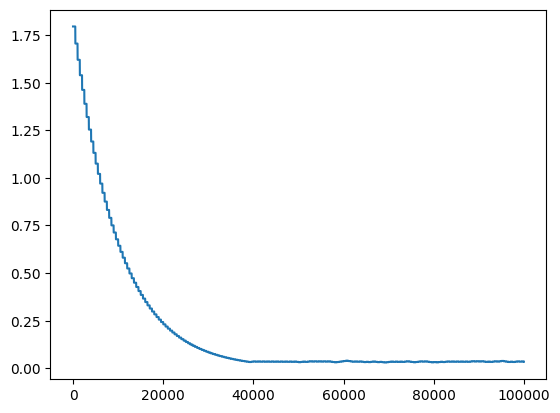

In [5]:
import matplotlib.pyplot as plt
import numpy as np
x = np.arange(0, n_steps)
plt.plot(x, drmax)

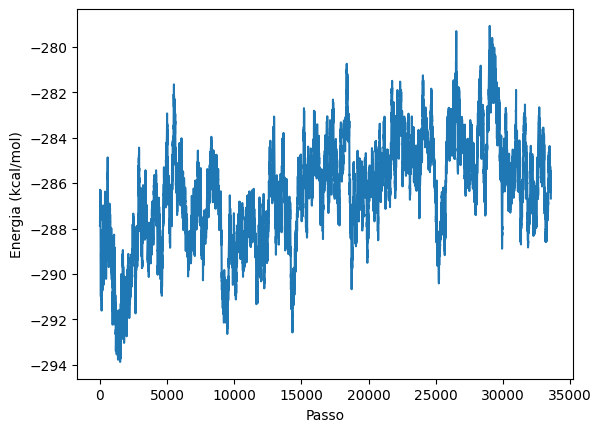

In [6]:
import matplotlib.pyplot as plt
import numpy as np
x = np.arange(0, indx)
plt.plot(x, en)
plt.ylabel('Energia (kcal/mol)')
plt.xlabel('Passo')
plt.savefig('monte_carlo.jpg')

In [7]:
system.convertUnitsInv()
system.save('system_new.json')